# Q&A Chat Bot

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Data

We work with the Babi Data Set from Facebook Research.

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698


In [76]:
import pickle
import numpy as np

In [77]:
# Unpickling file for training data
with open("/content/drive/MyDrive/Colab Notebooks/6120/Project/train_qa.txt", "rb") as fp:
    train_data =  pickle.load(fp)

In [78]:
# Unpickling file for testing data
with open("/content/drive/MyDrive/Colab Notebooks/6120/Project/test_qa.txt", "rb") as fp:
    test_data =  pickle.load(fp)

----

## Exploring the Format of the Data

In [79]:
type(train_data)
type(test_data)

list

In [80]:
len(train_data)
len(test_data)

1000

In [81]:
# train_data[0]

In [82]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [83]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [84]:
train_data[0][2]

'no'

-----

## Setting up Vocabulary of All Words

In [85]:
# Create a set that holds the vocab words
vocab = set()

In [86]:
all_data = train_data + test_data

In [87]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [88]:
vocab.add('no')
vocab.add('yes')

In [89]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [90]:
vocab_len = len(vocab) + 1

print(vocab_len)

38


In [91]:
max_story_len = max([len(data[0]) for data in all_data])

In [92]:
max_story_len

156

In [93]:
max_question_len = max([len(data[1]) for data in all_data])

In [94]:
max_question_len

6

## Vectorizing the Data

In [95]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [96]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

-----------

In [97]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [98]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [99]:
tokenizer.word_index

{'bathroom': 1,
 'sandra': 2,
 'bedroom': 3,
 'grabbed': 4,
 'put': 5,
 'dropped': 6,
 'football': 7,
 'kitchen': 8,
 'the': 9,
 'daniel': 10,
 'back': 11,
 'went': 12,
 'up': 13,
 'no': 14,
 'picked': 15,
 'took': 16,
 'milk': 17,
 'discarded': 18,
 'moved': 19,
 'is': 20,
 'travelled': 21,
 'left': 22,
 'john': 23,
 'mary': 24,
 'journeyed': 25,
 'yes': 26,
 'down': 27,
 'garden': 28,
 '.': 29,
 'there': 30,
 'to': 31,
 'got': 32,
 'apple': 33,
 'hallway': 34,
 'office': 35,
 '?': 36,
 'in': 37}

In [100]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [101]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [102]:
len(train_story_text)

10000

In [103]:
len(train_story_seq)

10000

In [104]:
# word_index = tokenizer.word_index

### Functionalize Vectorization

In [105]:
def vectorize_text(content, word_index = tokenizer.word_index, 
                   max_story_len = max_story_len, 
                   max_question_len = max_question_len):
    '''
    INPUT: 
    content: including Stories, Queries, & Answers
    word_index: word index dictionary from tokenizer
    max_story_len: length of the longest story (for pad_sequences)
    max_question_len: length of the longest question (for pad_sequences)
    OUTPUT:
    Vectorizes stories, questions, and answers into padded sequences. 
    First loop for every story, query, and answer in whole dataset. 
    Then convert raw words to word index value. 
    After that append each set to their appropriate output list. 
    Once converted words to numbers, pad sequences for equal length.
    Returns this in form of tuple (X,Xq,Y) (padded based on max lengths)
    '''
    # X = Stories
    X = []
    # Xq = Queries
    Q = []
    # Y = Answers
    Y = []
    
    for story, query, answer in content:
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        q = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Q.append(q)
        Y.append(y)

    # pad the sequences based on max length so RNN can be trained on same lenth sequences.
    # Return Tuple for unpacking
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Q, maxlen=max_question_len), np.array(Y))

In [106]:
# inputs_train, queries_train, answers_train = vectorize_text(train_data)
train_stories, train_questions, train_answers = vectorize_text(train_data)        

In [107]:
# inputs_test, queries_test, answers_test = vectorize_text(test_data)
test_stories, test_questions, test_answers = vectorize_text(test_data)


In [108]:
train_stories

array([[ 0,  0,  0, ...,  9,  3, 29],
       [ 0,  0,  0, ...,  9, 34, 29],
       [ 0,  0,  0, ...,  9,  1, 29],
       ...,
       [ 0,  0,  0, ...,  9,  3, 29],
       [ 0,  0,  0, ..., 17, 30, 29],
       [ 0,  0,  0, ..., 33, 30, 29]], dtype=int32)

In [109]:
train_questions

array([[20,  2, 37,  9, 34, 36],
       [20, 10, 37,  9,  1, 36],
       [20, 10, 37,  9, 35, 36],
       ...,
       [20,  2, 37,  9, 34, 36],
       [20, 24, 37,  9,  8, 36],
       [20, 24, 37,  9,  3, 36]], dtype=int32)

In [110]:
train_answers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
Answer_counts = sum(train_answers)

In [112]:
# get the index of word 'yes'
tokenizer.word_index['yes']

26

In [113]:
# get the index of word 'no'
tokenizer.word_index['no']

14

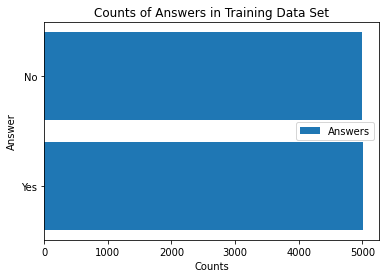

In [114]:
import matplotlib.pyplot as plt

# Pass the x and y cordinates of the bars to the
# function. The label argument gives a label to the data.
plt.barh(["Yes", "No"], 
         [Answer_counts[tokenizer.word_index['yes']], 
          Answer_counts[tokenizer.word_index['no']]], 
         align='center', label="Answers")
plt.legend()

plt.ylabel('Answer')
plt.xlabel('Counts')
plt.title('Counts of Answers in Training Data Set')

plt.show()

## Create LSTM Model

In [115]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

### Placeholders for Inputs

We got two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.


In [116]:
story_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Building the Networks

The theory behind "End-To-End Memory Networks":

* Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Stories Encoder m

In [117]:
# Input gets embedded to a sequence of vectors
story_encoder_m = Sequential()
story_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64))
story_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Stories Encoder c

In [118]:
# embed the input into a sequence of vectors of size query_maxlen
story_encoder_c = Sequential()
story_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_len))
story_encoder_c.add(Dropout(0.3))

# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [119]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size,
                               output_dim = 64,
                               input_length = max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [120]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
story_encoded_m = story_encoder_m(story_sequence)
story_encoded_c = story_encoder_c(story_sequence)
question_encoded = question_encoder(question)

##### Use dot product to compute the match between first input vector seq and the query

In [121]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([story_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

#### Add this match matrix with the second input vector sequence

In [122]:
# add the match matrix with the second input vector sequence
response = add([match, story_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

#### Concatenate

In [123]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [124]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [125]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [126]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [127]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build final model
model = Model([story_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, None, 64)     2432        ['input_3[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 6, 64)        2432        ['input_4[0][0]']                
                                                                                            

In [129]:
# train
history = model.fit([train_stories, train_questions], train_answers, batch_size=32, epochs=120, validation_data = ([test_stories, test_questions], test_answers))

Epoch 1/120
313/313 [==============================] - 4s 8ms/step - loss: 0.9080 - accuracy: 0.4964 - val_loss: 0.6978 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 2s 7ms/step - loss: 0.7022 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6954 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.4990 - val_loss: 0.6998 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6951 - accuracy: 0.5004 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 7/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.4910 - val_loss: 0.6939 - val_accuracy: 0.4970

### Saving the Model

In [130]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

## Evaluating the Model

### Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


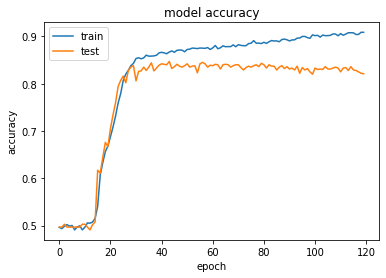

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [132]:
filename = 'chatbot_120_epochs.h5'

In [133]:
model.load_weights(filename)
pred_results = model.predict(([test_stories, test_questions]))

32/32 [==============================] - 0s 3ms/step


In [134]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [135]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [136]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [137]:
# Generate prediction from model
val_max = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999987


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [138]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

# my_question = "Is the football in the garden ?"
my_question = "Is football in the kitchen ?"

# mydata = [(my_story.split(),my_question.split(), 'yes')]
mydata = [(my_story.split(),my_question.split(), 'no')]
my_story,my_ques,my_ans = vectorize_text(mydata)
pred_results = model.predict(([my_story, my_ques]))

#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

1/1 [==============================] - 0s 19ms/step
Predicted answer is:  no
Probability of certainty was:  0.99996114


In [139]:
print(pred_results)

[[9.45671289e-14 1.18065266e-13 8.98767348e-14 9.12255975e-14
  1.05052895e-13 1.08789436e-13 8.45099950e-14 1.09731397e-13
  8.18240264e-14 9.01787800e-14 1.02674949e-13 9.71587922e-14
  1.04499729e-13 9.56426236e-14 9.99961138e-01 9.91834111e-14
  9.28231558e-14 7.94937439e-14 8.77584070e-14 1.01636425e-13
  1.12194413e-13 8.59601154e-14 8.16911575e-14 9.51896507e-14
  8.56521004e-14 1.00592291e-13 3.88829176e-05 1.06260819e-13
  9.40004842e-14 1.12424908e-13 9.70524727e-14 1.01742528e-13
  9.44386103e-14 1.02031109e-13 9.02388244e-14 1.10393079e-13
  9.72045727e-14 8.11937594e-14]]


In [140]:
my_story2 = "Daniel went there . Mary is in kitchen ."
my_question2 = "Is Daniel there ?"
my_answer2 = 'yes'
# my_answer2 = 'no'

mydata2 = [(my_story2.split(), my_question2.split(), my_answer2)]
my_story2, my_ques2, my_ans2 = vectorize_text(mydata2)
new_result = model.predict(([my_story2, my_ques2]))

val_max2 = np.argmax(new_result[0])
for key, val in tokenizer.word_index.items():
    if val == val_max2:
        k = key
print("Predicted answer is: ", k)
print(new_result[0][tokenizer.word_index['yes']] > new_result[0][tokenizer.word_index['no']])
print("Probability of certainty was: ", new_result[0][val_max2])

1/1 [==============================] - 0s 15ms/step
Predicted answer is:  no
False
Probability of certainty was:  0.63023716


In [141]:
print(new_result)

[[5.4665040e-13 6.2631833e-13 5.6319890e-13 6.0285544e-13 4.6239992e-13
  5.2142752e-13 4.8508111e-13 6.3022612e-13 5.5255534e-13 5.0763972e-13
  6.2079514e-13 5.0702140e-13 5.7272194e-13 5.1290114e-13 6.3023716e-01
  5.4723256e-13 5.3647001e-13 5.0054031e-13 4.7860012e-13 5.3872895e-13
  5.5264181e-13 5.3979146e-13 4.8504408e-13 4.7562621e-13 5.8580517e-13
  5.4812676e-13 3.6976284e-01 5.1070666e-13 5.3756907e-13 5.3361363e-13
  5.3120897e-13 5.3808200e-13 5.0932338e-13 5.6836903e-13 4.6688781e-13
  5.6810459e-13 5.3737841e-13 4.7788954e-13]]
